In [ ]:
import data_transform
import importlib
importlib.reload(data_transform)
from data_transform import get_data
import baseline
importlib.reload(baseline)
import cgvae
importlib.reload(cgvae)
import torch
from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [ ]:
dataloader, dataset_size = get_data()

In [ ]:
data = next(iter(dataloader))

In [ ]:
torch.sum(data['input'].x == 1)

In [7]:
baseline_net = baseline.train(
    device='cpu',
    dataloader=dataloader,
    num_node_features=1433,
    learning_rate=0.01,
    num_epochs=100,
    model_path='baseline_net.pth'
)

NN Epoch 99         : 100%|██████████| 1/1 [00:00<00:00, 11.54it/s, loss=0.42]


In [8]:
cgvae_net = cgvae.train(
    device='cpu',
    dataloader=dataloader,
    learning_rate=0.005,
    num_epochs=200,
    pre_trained_baseline_net=baseline_net
)

CVAE Epoch 199      : 100%|██████████| 1/1 [00:00<00:00,  1.34it/s, loss=0.4157]


In [ ]:
# generate missing part based on the trained model

In [11]:
# sample one data from the dataloader
graphs = next(iter(dataloader))

# Visualize the input graph

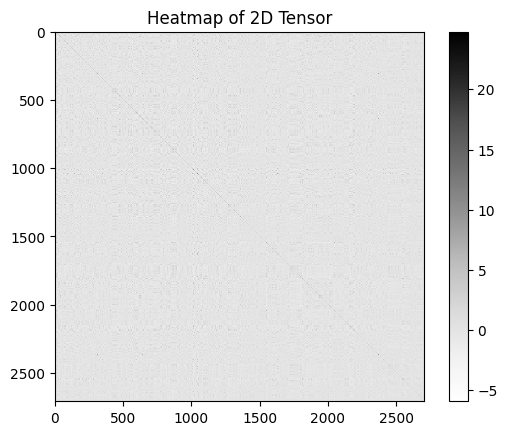

In [16]:
import matplotlib.pyplot as plt
# Convert the tensor to a NumPy array
# Plot the heatmap
plt.imshow(baseline_net(graphs['input']).detach().numpy(), cmap='Greys', interpolation='nearest')
plt.colorbar()  # Add a colorbar to a plot
plt.title("Heatmap of 2D Tensor")
plt.show()

In [ ]:
cgvae_net